# Ex2 - Solution

## Q1

### Objective
In this question, you will implement the power method to estimate the dominant right singular
vector of a matrix $A∈R^{n×m}$, where $n>m$. You will explore how the choice of initialization affects
convergence and visualize the error across iterations. Your implementation will be compared against
the true singular vectors obtained from the SVD.

### (A) Generating a Matrix with a Singular Value Gap
To test the power method, you will construct a matrix with a large singular value gap.

In [42]:
import numpy as np
np.random.seed(0)

n, m = 100, 50 # A will be n x m

# Generate U and V from a random matrix SVD
A_rand = np.random.randn(n, m)
U, _, Vt = np.linalg.svd(A_rand, full_matrices=False)

# Define singular values with a gap
s = np.linspace(10, 1, m)
s[1:] *= 0.1 # Compress all except the top singular value
S = np.diag(s)

# Construct matrix A
A = U @ S @ Vt

Note: We construct $A∈R^{n×m}$ using its singular value decomposition: $$A=USV^T$$

Here, $U$ and $V$ are obtained from the SVD of a random matrix, and we manually define $S$ to have
a large gap between the first and remaining singular values. **Try to explain why?**

We introduce a big gap so that the dominant singular vector is uniquely defined, the power method converges rapidly (since $\sigma_2/\sigma_1\ll1$), and we can clearly observe and compare convergence behaviors under different initializations.

**Plot the singular values of $A$.**

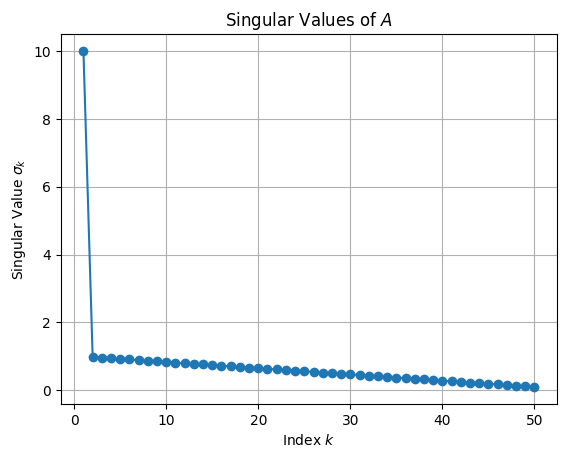

In [43]:
import numpy as np
import matplotlib.pyplot as plt

# Compute and plot singular values
singular_values = np.linalg.svd(A, compute_uv=False)

plt.figure()
plt.plot(np.arange(1, m+1), singular_values, marker='o')
plt.xlabel('Index $k$')
plt.ylabel('Singular Value $\\sigma_k$')
plt.title('Singular Values of $A$')
plt.grid(True)
plt.show()


### (B) Implementing the Power Method
Implement the power method on $A^TA∈R^{m×m}$ to estimate the top right singular vector.

#### 1. Write a function power_method(A, v0, num_iter) which:
-  Starts with an initial vector $v_0∈R^m$
- Iteratively computes $v_{k+1} = A^TAv_k$, and normalize the result
- Returns the iterates $v_k$ at each step

In [44]:
import numpy as np

def power_method(A: np.ndarray, v0: np.ndarray, num_iter: int):
    """
    Estimate the dominant right singular vector of A using the power method on A^T A.

    Parameters
    ----------
    A : array_like, shape (n, m)
        The input matrix.
    v0 : array_like, shape (m,)
        Initial guess for the right singular vector.
    num_iter : int
        Number of power‐method iterations to perform.

    Returns
    -------
    iterates : list of ndarray, length num_iter+1
        Sequence [v^(0), v^(1), …, v^(num_iter)], where each v^(k) is normalized.
    """
    # ensure numpy arrays
    A = np.asarray(A)
    v = np.asarray(v0, dtype=float)
    
    # normalize initial vector
    v /= np.linalg.norm(v)
    iterates = [v.copy()]
    
    for _ in range(num_iter):
        # apply AᵀA
        w = A.T @ (A @ v)
        # normalize
        v = w / np.linalg.norm(w)
        iterates.append(v.copy())
    
    return iterates


#### 2. Briefly explain our expectations for this algorithm’s outcomes.


We should see convergence to the top singular direction.
regardless of a “random” $v_0$ (so long as it isn’t orthogonal to the true $v_1$), the iterates $v^{(k)}$ rapidly align with the dominant right‐singular vector of $A$.
also, a geometric error decay which is the angle (or norm‐difference) to the true $v_1$ shrinks roughly by a factor of $\sigma_2/\sigma_1$ each iteration—so with a big gap we'll get fast convergence.
unless we start exactly perpendicular to $v_1$, different $v_0$ choices all end up at the same $v_1$; only the speed varies.


### (C) Initializations

#### 1. Generate two vectors that will be used for initialization:
- A random unit vector $v_{rand}∼N(0,I)$
- A vector $v_{orth}$ that is almost orthogonal to the main singular vector. Think about how to do this effectively.

In [45]:
import numpy as np

n, m = A.shape

# get the true top right singular vector v₁
_, _, Vt = np.linalg.svd(A, full_matrices=False)
v1 = Vt[0]                 # shape (m,)


# a random unit‐vector
vrand = np.random.randn(m)
vrand /= np.linalg.norm(vrand)

# an “almost” orthogonal vector (so it has a tiny component along v₁, not exactly zero)
# start with some random v
v_temp = np.random.randn(m)
v_temp /= np.linalg.norm(v_temp)

# project out the v₁–component → exact orthogonal
v_orth_exact = v_temp - np.dot(v_temp, v1) * v1
v_orth_exact /= np.linalg.norm(v_orth_exact)

# now add a small ε·v₁ so it’s not perfectly orthogonal
epsilon = 1e-3
vorth = v_orth_exact + epsilon * v1
vorth /= np.linalg.norm(vorth)

# check
print("dot(v1, vrand)  =", np.dot(v1, vrand))
print("dot(v1, vorth)  =", np.dot(v1, vorth))


dot(v1, vrand)  = -0.028914766615874207
dot(v1, vorth)  = 0.000999999500000362


#### 2. Plot them on the same figure.

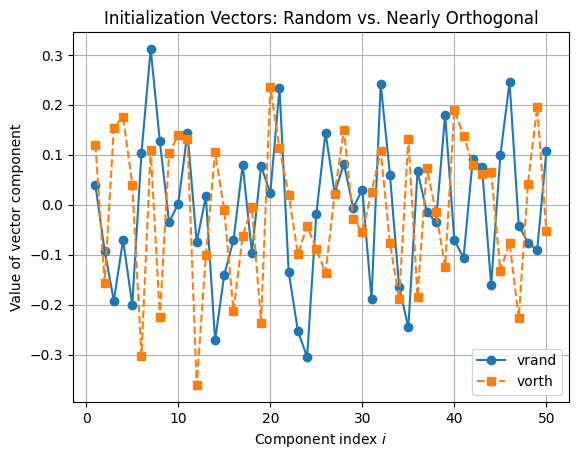

In [46]:
indices = np.arange(1, m+1)

plt.figure()
plt.plot(indices, vrand,  marker='o', linestyle='-', label='vrand')
plt.plot(indices, vorth, marker='s', linestyle='--', label='vorth')
plt.xlabel('Component index $i$')
plt.ylabel('Value of vector component')
plt.title('Initialization Vectors: Random vs. Nearly Orthogonal')
plt.legend()
plt.grid(True)
plt.show()

### (D) Measuring Convergence

#### 1. For each iterate $v_k$, compute the alignment with the true singular vector $v_1$ using the cosine distance: $$error_k = 1 −|⟨v_k,v_1⟩|$$

In [47]:
import numpy as np

def compute_errors(iterates, v1):
    """
    Given a list of normalized iterates [v⁽⁰⁾, v⁽¹⁾, …] and the true top singular vector v1,
    return the list of errors error_k = 1 - |⟨v⁽ᵏ⁾, v1⟩|.
    """
    return [1 - abs(np.dot(vk, v1)) for vk in iterates]

#### 2. Plot this error as a function of iteration $k$, for both initializations.

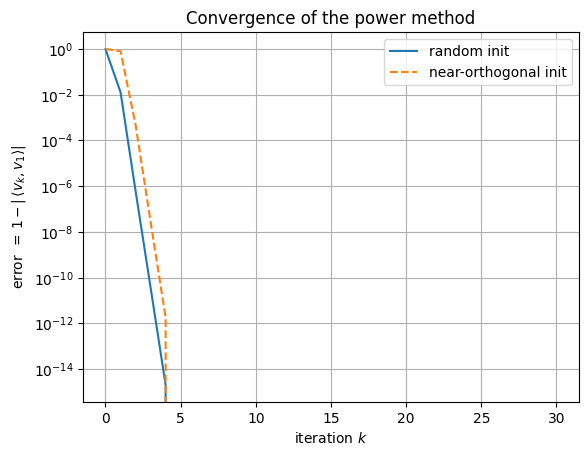

In [48]:
# --- parameters ---
num_iter = 30          # how many power-method steps to run

# --- run power method ---
iter_rand  = power_method(A, vrand,  num_iter)
iter_orth  = power_method(A, vorth,  num_iter)

# --- compute cosine-distance errors ---
err_rand = compute_errors(iter_rand, v1)
err_orth = compute_errors(iter_orth, v1)

# --- plot ---
import matplotlib.pyplot as plt

plt.figure()
plt.semilogy(err_rand,  label='random init')
plt.semilogy(err_orth,  label='near-orthogonal init', linestyle='--')
plt.xlabel('iteration $k$')
plt.ylabel(r'error $\,=\,1-|\,\langle v_k, v_1\rangle|$')
plt.title('Convergence of the power method')
plt.legend()
plt.grid(True, which='both')
plt.show()


#### 3. Observe how convergence differs between the random and orthogonal starts. Discuss the difference between them.

TODO

#### 4. At each iteration $k$, compute the Rayleigh quotient: $$ρ_k = \|Av_k\|$$

In [ ]:
# Compute Rayleigh quotients for both initializations
def compute_rayleigh_quotients(A, iterates):
    """
    Compute the Rayleigh quotient ρ_k = ‖Avk‖ for each iterate vk
    """
    return [np.linalg.norm(A @ vk) for vk in iterates]

rayleigh_rand = compute_rayleigh_quotients(A, iter_rand)
rayleigh_orth = compute_rayleigh_quotients(A, iter_orth)

#### 5. Plot $ρ_k$ as a function of $k$, and compare it to the top singular value $σ_1$. Explain your results.

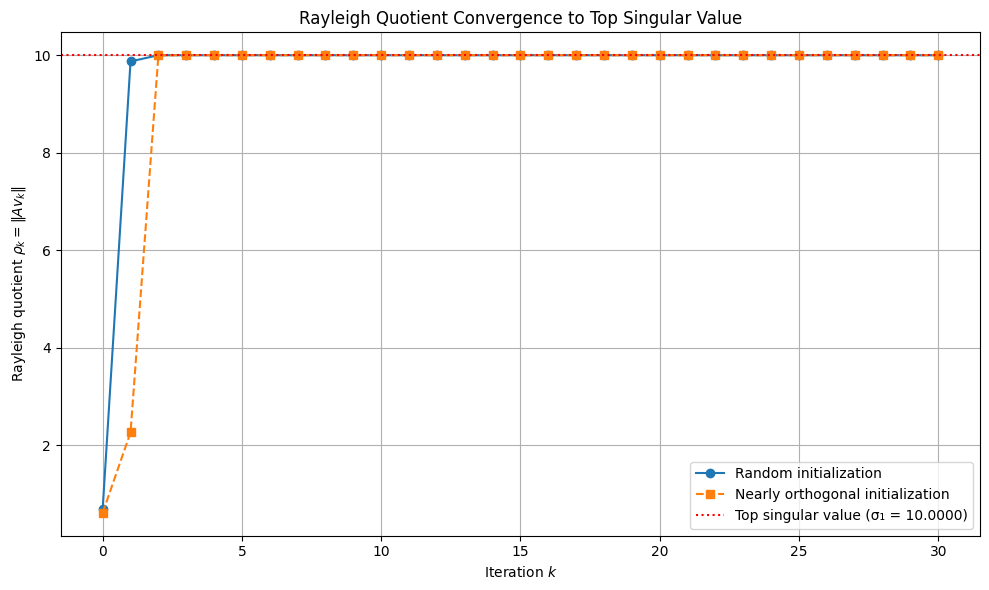

Top singular value (σ₁): 10.000000
Final Rayleigh quotient (random): 10.000000
Final Rayleigh quotient (orthogonal): 10.000000


In [ ]:
# Get the top singular value for comparison
_, singular_values, _ = np.linalg.svd(A, full_matrices=False)
sigma1 = singular_values[0]

# Plot the Rayleigh quotients
plt.figure(figsize=(10, 6))
plt.plot(range(num_iter + 1), rayleigh_rand, 'o-', label='Random initialization')
plt.plot(range(num_iter + 1), rayleigh_orth, 's--', label='Nearly orthogonal initialization')
plt.axhline(y=sigma1, color='r', linestyle=':', label=f'Top singular value (σ₁ = {sigma1:.4f})')
plt.xlabel('Iteration $k$')
plt.ylabel('Rayleigh quotient $\\rho_k = \\|Av_k\\|$')
plt.title('Rayleigh Quotient Convergence to Top Singular Value')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Print the final values for comparison
print(f"Top singular value (σ₁): {sigma1:.6f}")
print(f"Final Rayleigh quotient (random): {rayleigh_rand[-1]:.6f}")
print(f"Final Rayleigh quotient (orthogonal): {rayleigh_orth[-1]:.6f}")